<a href="https://colab.research.google.com/github/vanshbhagt23/MovieRecommendationSystems/blob/main/MRS_AI_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Libaraies**

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from wordcloud import WordCloud
import seaborn as sns
import warnings
import sklearn.metrics as metrics
warnings.filterwarnings("ignore")

In [ ]:
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.layers import Concatenate, Dense, Dropout
from keras.layers import Add, Activation, Lambda

import tensorflow as tf
import keras
from pprint import pprint

In [ ]:
DATASET_LINK='http://files.grouplens.org/datasets/movielens/ml-100k.zip'

In [ ]:
!wget -nc https://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip -n ml-100k.zip

--2022-12-14 04:24:26--  https://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  10.0MB/s    in 0.5s    

2022-12-14 04:24:27 (10.0 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.ba

**Loading MovieLens dataset**


Loading u.info -- The number of users, items, and ratings in the u data set.

In [ ]:
overall_stats = pd.read_csv('ml-100k/u.info', header=None)
print("Details of users, items and ratings involved in the loaded movielens dataset: ",list(overall_stats[0]))

Details of users, items and ratings involved in the loaded movielens dataset:  ['943 users', '1682 items', '100000 ratings']


Each user has rated at least 20 movies.  Users and items are numbered consecutively from 1.  The data is randomly ordered. This is a tab separated list of user id | item id | rating | timestamp. 
The time stamps are unix seconds since 1/1/1970 UTC 

In [ ]:
## same item id is same as movie id, item id column is renamed as movie id
dateparse = lambda x: datetime.utcfromtimestamp(int(x)).strftime('%Y-%m-%d %H:%M:%S')
column_names1 = ['user id','movie id','rating','timestamp']
ratings_dataset = pd.read_csv('ml-100k/u.data', sep='\t',header=None,names=column_names1,parse_dates=['timestamp'], date_parser=dateparse)
ratings_dataset.head()

,user id,movie id,rating,timestamp
0,196,242,3,1997-12-04 15:55:49
1,186,302,3,1998-04-04 19:22:22
2,22,377,1,1997-11-07 07:18:36
3,244,51,2,1997-11-27 05:02:03
4,166,346,1,1998-02-02 05:33:16


In [ ]:
d = 'movie id | movie_title | release_date | video release date | IMDb URL | unknown | Action | Adventure | Animation | Children | Comedy | Crime | Documentary | Drama | Fantasy | Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi | Thriller | War | Western'
column_names2 = d.split(' | ')
print(column_names2)

['movie id', 'movie_title', 'release_date', 'video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


In [ ]:
items_dataset = pd.read_csv('ml-100k/u.item', sep='|',header=None,names=column_names2,encoding='latin-1')
items_dataset.head()

,movie id,movie_title,release_date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
items_dataset.release_date = pd.to_datetime(items_dataset.release_date)

In [ ]:
movie_dataset = items_dataset[['movie id', 'movie_title']]
movie_dataset.head()

,movie id,movie_title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [ ]:
## looking at length of original items_dataset and length of unique combination of rows in items_dataset after removing movie id column
len(items_dataset.groupby(by=column_names2[1:])),len(items_dataset)

(1664, 1682)

We can see there are 18 extra movie id's for already mapped movie title and the same duplicate movie id is assigned to the user in the user-item dataset.

In [ ]:
user_df = pd.read_csv('ml-100k/u.user', sep='|', encoding='latin-1',
                     names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])
user_df.head()

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


If you notice at various places, we have used word age group, which is not already there, so lets go ahead and create one additional categorical feature in user_df called age_group. Minimum age is 7 and maximum age is 73 so we should have following divisions:

1. 5-12 - Gradeschooler
2. 13-19 - Teenager
3. 20-35 - Young
4. 35-55 - Midlife
5. above 55 - Old

In [ ]:
user_df['age_group'] = user_df.age.apply(lambda age: 'Gradeschooler' if 5<=age<=12 else ('Teenager' if 13<=age<=19 else ('Young' if 20<=age<=35 else ('Midlife' if 35<=age<=55 else 'Old'))))
user_df.sample(5)

,user_id,age,gender,occupation,zip_code,age_group
159,160,27,M,programmer,66215,Young
715,716,36,F,administrator,44265,Midlife
500,501,22,M,student,10025,Young
521,522,36,M,engineer,55443,Midlife
175,176,28,M,scientist,07030,Young


In [ ]:
rating_user_df = ratings_dataset.join(other=user_df, how='inner', on='user id', lsuffix='_R')
rating_user_items_dataset = rating_user_df.join(other=items_dataset, how='inner', on='movie id', rsuffix='_M')
rating_movie_df = ratings_dataset.join(other=items_dataset, how='inner', on='movie id', rsuffix='_M')

EDA: Finding Insight

What are common genere of movies?

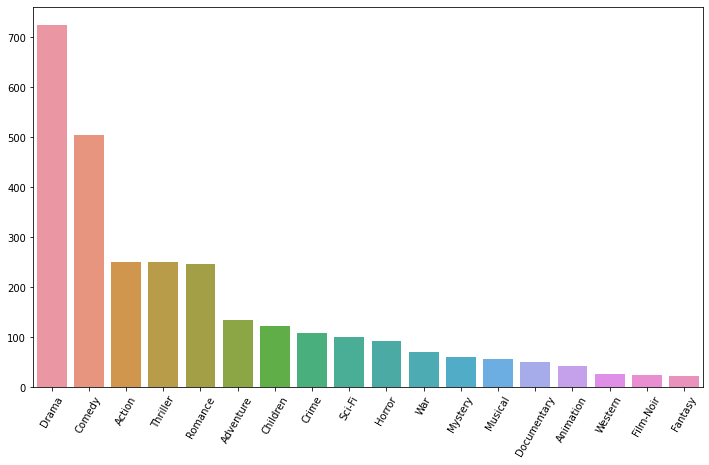

In [ ]:
generes = ['Action','Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary',
           'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery','Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

plt.figure(figsize=(12,7))
genere_counts = items_dataset.loc[:,generes].sum().sort_values(ascending=False)
sns.barplot(x=genere_counts.index, y=genere_counts.values)
plt.xticks(rotation=60);

Observations: Drama and comedy are the most common genere type. We must also note that it can not be a clear indication of people's preference, because One movie can have more than one genere and drama is the most commor genere type.

**How many movies got released each year and month?**

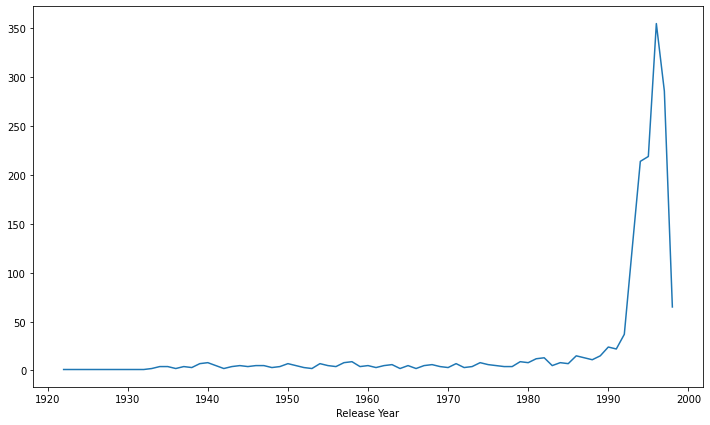

In [ ]:
plt.figure(figsize=(12,7))
yearly_release_counts = items_dataset.groupby(items_dataset.release_date.dt.year).size().sort_values(ascending=False)
sns.lineplot(yearly_release_counts.index, yearly_release_counts.values);
plt.xlabel('Release Year');

Release significantly increased after 80s, however it doesn't exactly depicts the actual number of release, but the number of rated release, actual number of release must be far greater than what we have. Anyway, one thing is clear that people mostly watched movies released in 90s. There is a sudden fall in 1998's record, that might be because of incomplete record.

Since there is not much record available for movies before 90s, so I will consider release count for months in 90s only.`

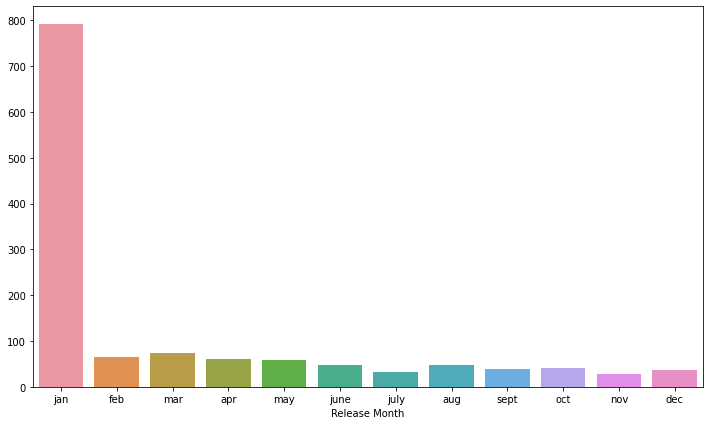

In [ ]:
plt.figure(figsize=(12,7))
monthly_release_counts = items_dataset[items_dataset.release_date.dt.year > 1990].groupby(items_dataset.release_date.dt.month).size()
sns.barplot(['jan', 'feb', 'mar', 'apr', 'may', 'june', 'july', 'aug', 'sept', 'oct', 'nov', 'dec'], monthly_release_counts.values);
plt.xlabel('Release Month');

Rated movie relase count in Jan month is too high as cmpare to other months. Dataset creators must have considered Jan 1st as the default release month and date.

What is the prefferable day of week to release movies?

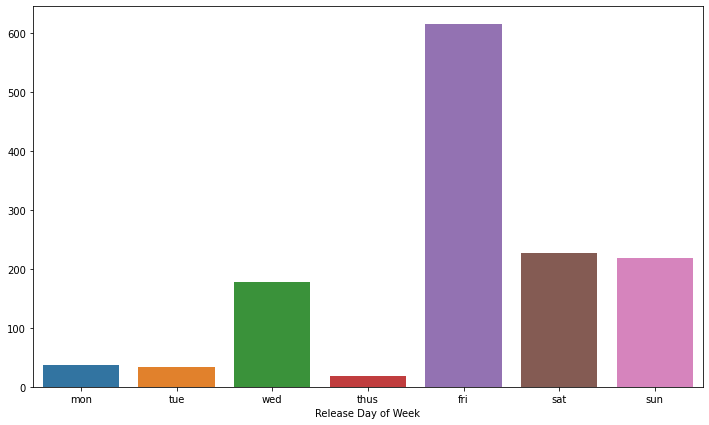

In [ ]:
plt.figure(figsize=(12,7))
weekday_release_counts = items_dataset[items_dataset.release_date.dt.year > 1990].groupby(items_dataset.release_date.dt.dayofweek).size()
sns.barplot(['mon', 'tue', 'wed', 'thus', 'fri', 'sat', 'sun'], weekday_release_counts.values);
plt.xlabel('Release Day of Week');

**Who watches more movies Men/Women?**

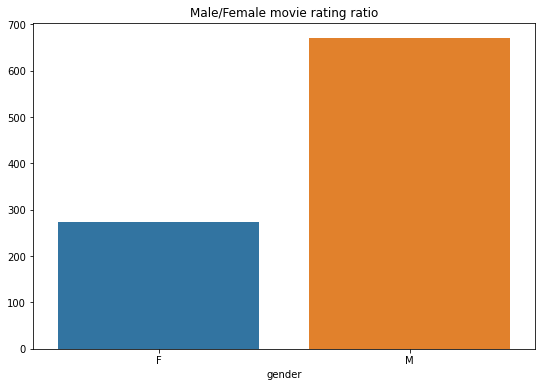

In [ ]:
plt.figure(figsize=(9,6))
sns.barplot(user_df.groupby('gender').size().index, user_df.groupby('gender').size().values)
plt.title('Male/Female movie rating ratio');

What age group watches more movies?

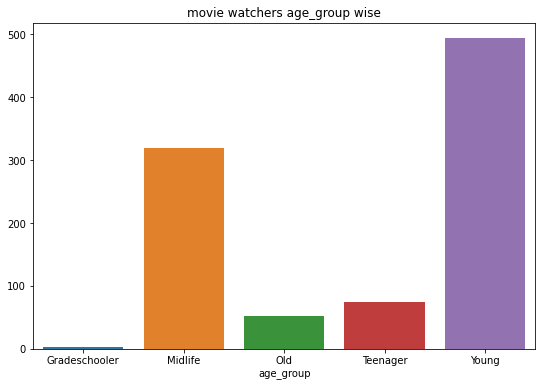

In [ ]:
plt.figure(figsize=(9,6))
sns.barplot(user_df.groupby('age_group').size().index, user_df.groupby('age_group').size().values)
plt.title('movie watchers age_group wise');

Obviously Gradeschoolers and Teenagers don't have that much of time and old people don't have much interestest. Youngesters are the ones who watches movies mostly and prefers rating them. So overall people from age 20 - 55 watches more movies.

**Which kind of occupant watches more movies?**

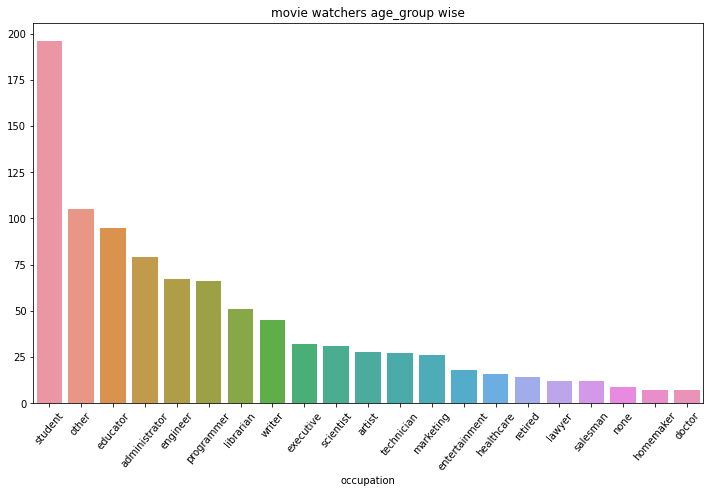

In [ ]:
plt.figure(figsize=(12,7))
movie_watcher_occupants = user_df.groupby('occupation').size().sort_values(ascending=False)
sns.barplot(movie_watcher_occupants.index, movie_watcher_occupants.values)
plt.title('movie watchers age_group wise')
plt.xticks(rotation=50);

It appears that Students watches more movies, may be the ones who are above 20 means Young students. Irony is that people who are in entertainment don't watch or may rate movies. Lets explore it bit more.

In [ ]:
pd.DataFrame(user_df.groupby(['occupation', 'age_group']).size().sort_values(ascending=False))

0
occupation age_group         
student    Young          128
           Teenager        62
other      Young           59
educator   Midlife         51
programmer Young           45
...                       ...
artist     Teenager         1
none       Gradeschooler    1
salesman   Teenager         1
retired    Midlife          1
none       Midlife          1

[62 rows x 1 columns]

From above dataframe it is clear that Young students are more interested in movies. After that Midelife people in any profession seems interested too.

**What gender likes which kind of genere** 

In [ ]:
temp_df = rating_user_items_dataset.groupby('gender').sum().loc[:,generes]
temp_df = temp_df.transpose()
temp_df

gender,F,M
Action,6297,14761
Adventure,3451,8256
Animation,1143,2665
Children,2433,5809
Comedy,9437,22131
Crime,2342,5429
Documentary,526,1188
Drama,11523,27333
Fantasy,407,1025
Film-Noir,543,1373


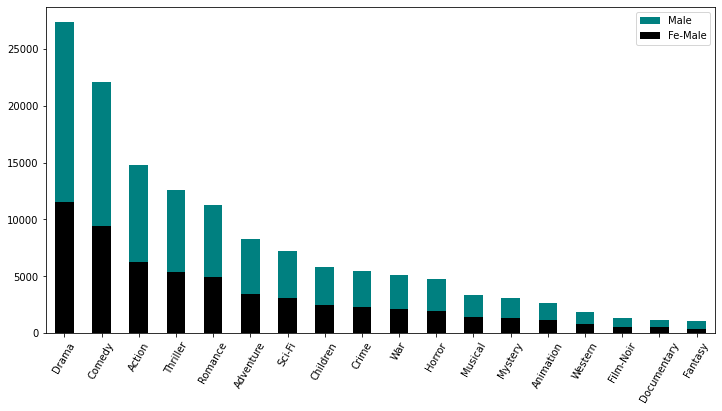

In [ ]:
plt.figure(figsize=(12, 6))

temp_df.M.sort_values(ascending=False).plot(kind='bar', color='teal', label="Male")
temp_df.F.sort_values(ascending=False).plot(kind='bar', color='black', label="Fe-Male")
plt.legend()
plt.xticks(rotation=60)
plt.show()

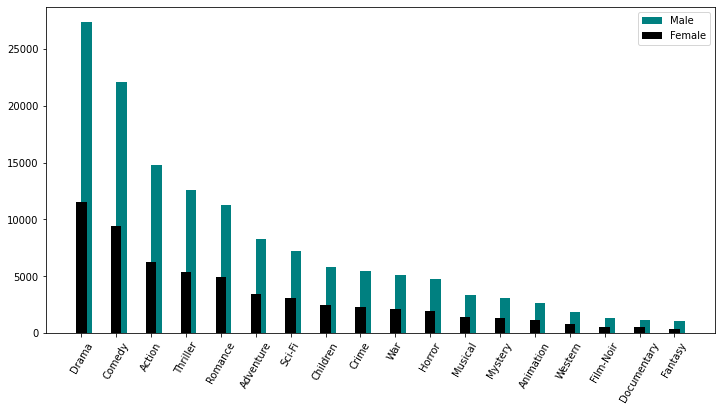

In [ ]:
plt.figure(figsize=(12, 6))
m_temp_df = temp_df.M.sort_values(ascending=False)
f_temp_df = temp_df.F.sort_values(ascending=False)

plt.bar(x=m_temp_df.index, height=m_temp_df.values, label="Male", align="edge", width=0.3, color='teal')
plt.bar(x=f_temp_df.index, height=f_temp_df.values, label="Female", width=0.3, color='black')
plt.legend()
plt.xticks(rotation=60)
plt.show()

**What age group watches which kind of movies?** 

In [ ]:
ratings_dataset.groupby(ratings_dataset.timestamp.dt.year).size()

timestamp
1997    52899
1998    47101
dtype: int64

**Gender Wise** 

In [ ]:
rating_user_df.groupby([rating_user_df.timestamp.dt.year, 'gender']).size()

timestamp  gender
1997       F         18311
           M         34550
1998       F         11474
           M         35497
dtype: int64

**Age group wise** 

In [ ]:
rating_user_df.groupby([rating_user_df.timestamp.dt.year, 'age_group']).size()

timestamp  age_group    
1997       Gradeschooler       91
           Midlife          18482
           Old               2439
           Teenager          4459
           Young            27390
1998       Gradeschooler       75
           Midlife          18020
           Old               2832
           Teenager          3453
           Young            22591
dtype: int64

**How much rating people give mostly.** 

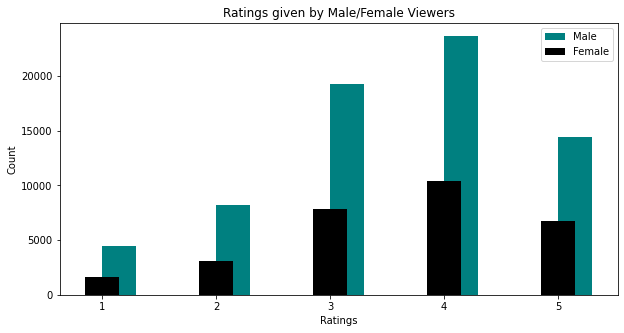

In [ ]:
temp_df = rating_user_df.groupby(['gender', 'rating']).size()
plt.figure(figsize=(10, 5))
m_temp_df = temp_df.M.sort_values(ascending=False)
f_temp_df = temp_df.F.sort_values(ascending=False)

plt.bar(x=m_temp_df.index, height=m_temp_df.values, label="Male", align="edge", width=0.3, color='teal')
plt.bar(x=f_temp_df.index, height=f_temp_df.values, label="Female", width=0.3, color='black')
plt.title('Ratings given by Male/Female Viewers')
plt.legend()
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

Viewers gave mostly 4 start rating then 3 and then 5

**Most Rated Movies** 

In [ ]:
def draw_horizontal_movie_bar(movie_titles, ratings_count, title=''):
    plt.figure(figsize=(12, 7))
    sns.barplot(y=movie_titles, x=ratings_count, orient='h')
    plt.title(title)
    plt.ylabel('Movies')
    plt.xlabel('Count')
    plt.show()

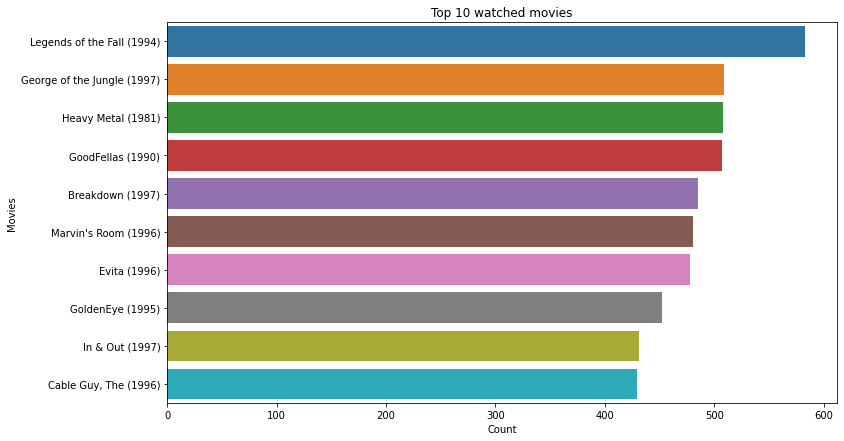

In [ ]:
top_ten_rated_movies = rating_movie_df.groupby('movie id').size().sort_values(ascending=False)[:10]
top_ten_movie_titles = items_dataset.iloc[top_ten_rated_movies.index].movie_title

draw_horizontal_movie_bar(top_ten_movie_titles.values, top_ten_rated_movies.values, 'Top 10 watched movies')

**Gender Wise**

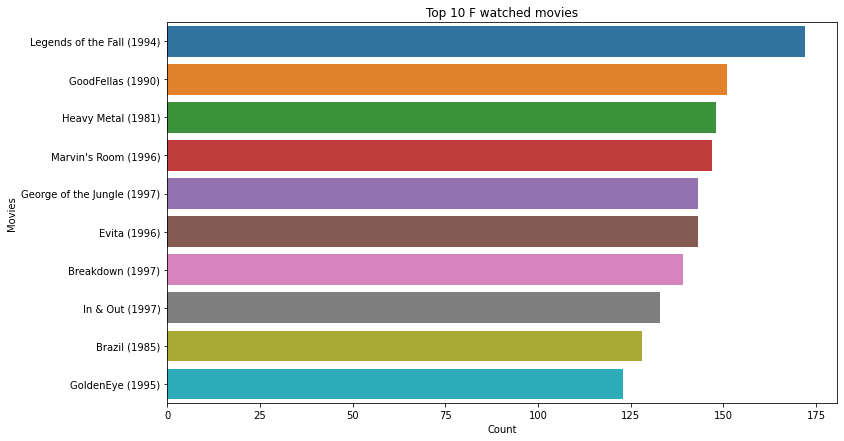

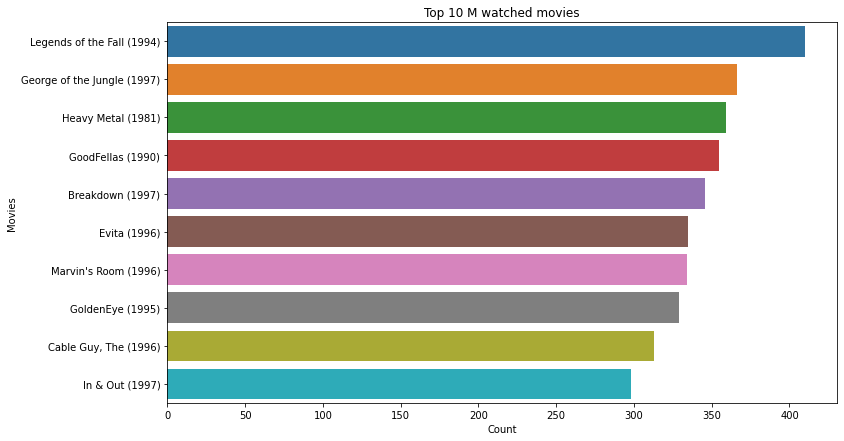

In [ ]:
top_rated_movies_gender_wise = rating_user_items_dataset.groupby(['gender','movie id']).size()

for index_label in top_rated_movies_gender_wise.index.get_level_values(0).unique():

    top_10_userkind_rated_movies = top_rated_movies_gender_wise[index_label].sort_values(ascending=False)[:10]
    top_10_userkind_rated_movie_titles = items_dataset.iloc[top_10_userkind_rated_movies.index].movie_title
    draw_horizontal_movie_bar(top_10_userkind_rated_movie_titles.values, top_10_userkind_rated_movies.values, f'Top 10 {index_label} watched movies')

**Age Group Wise** 

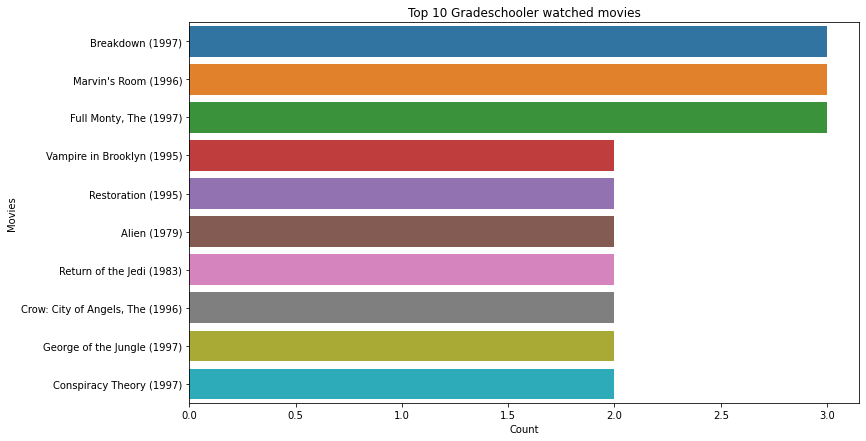

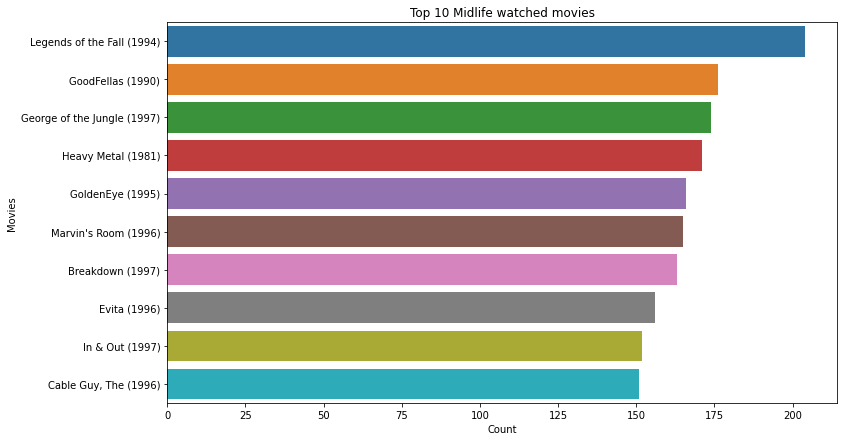

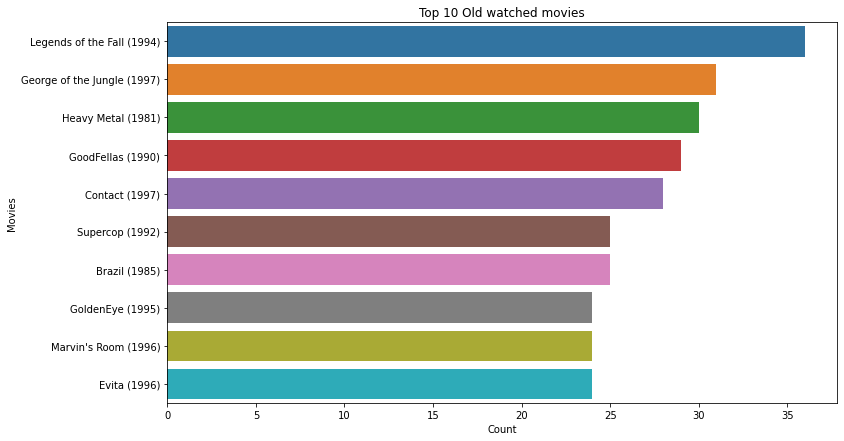

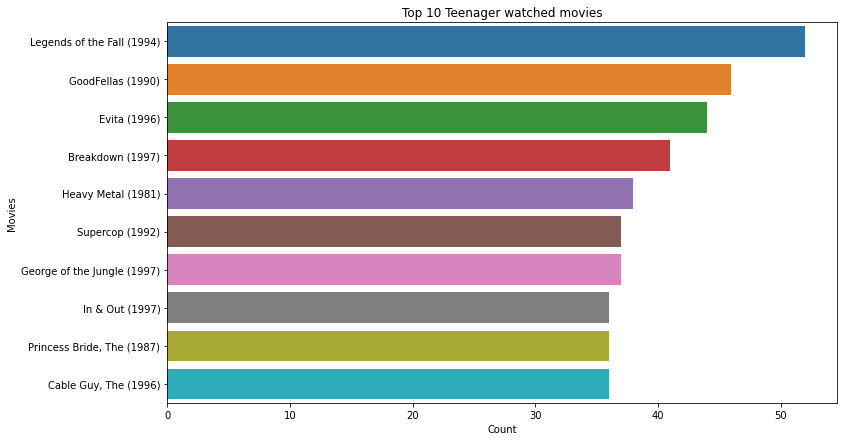

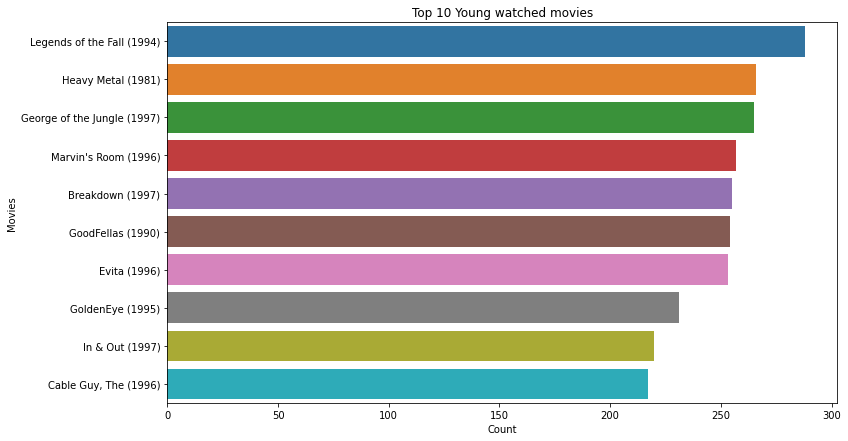

In [ ]:
top_rated_movies_age_group_wise = rating_user_items_dataset.groupby(['age_group','movie id']).size()

for index_label in top_rated_movies_age_group_wise.index.get_level_values(0).unique():
    top_10_userkind_rated_movies = top_rated_movies_age_group_wise[index_label].sort_values(ascending=False)[:10]
    top_10_userkind_rated_movie_titles = items_dataset.iloc[top_10_userkind_rated_movies.index].movie_title
    draw_horizontal_movie_bar(top_10_userkind_rated_movie_titles.values, top_10_userkind_rated_movies.values, f'Top 10 {index_label} watched movies')

**Worst movies as per user rating.** 

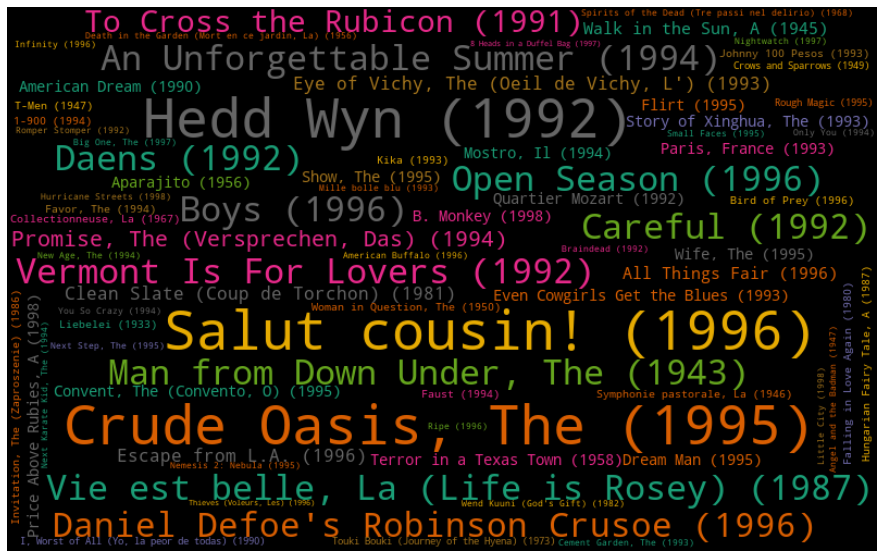

In [ ]:
movies_ratings_sum = rating_user_items_dataset.groupby('movie id').sum().rating.sort_values()
movies_ratings_sum.index = items_dataset.iloc[movies_ratings_sum.index].movie_title
# Will show movies with 0 < total_rating<= 10
lowest_rated_movies = movies_ratings_sum[movies_ratings_sum <= 10]


wordcloud = WordCloud(min_font_size=7, width=800, height=500, random_state=21, max_font_size=50, relative_scaling=0.5, colormap='Dark2')
# Substracted lowest_rated_movies from 11 so that we can have greater font size of least rated movies.
wordcloud.generate_from_frequencies(frequencies=(11-lowest_rated_movies).to_dict())
plt.figure(figsize=(16,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

**Merging required datasets**

In [ ]:
merged_dataset = pd.merge(ratings_dataset, movie_dataset, how='inner', on='movie id')
merged_dataset.head()

,user id,movie id,rating,timestamp,movie_title
0,196,242,3,1997-12-04 15:55:49,Kolya (1996)
1,63,242,3,1997-10-01 23:06:30,Kolya (1996)
2,226,242,5,1998-01-04 04:37:51,Kolya (1996)
3,154,242,3,1997-11-10 05:03:55,Kolya (1996)
4,306,242,5,1997-10-10 17:16:33,Kolya (1996)


A dataset is created from the existing merged dataset by grouping the unique user id and movie title combination and the ratings by a user to the same movie in different instances (timestamps) are averaged and stored in the new dataset.

Example of a multiple rating scenario by an user to a specific movie:

In [ ]:
merged_dataset[(merged_dataset['movie_title'] == 'Chasing Amy (1997)') & (merged_dataset['user id'] == 894)]

,user id,movie id,rating,timestamp,movie_title
4800,894,246,4,1997-12-18 00:15:37,Chasing Amy (1997)
22340,894,268,3,1997-11-18 23:34:01,Chasing Amy (1997)


**Creating a final refined dataset with unique user id, movie name combination and their ratings:**

In [ ]:
refined_dataset = merged_dataset.groupby(by=['user id','movie_title'], as_index=False).agg({"rating":"mean"})

refined_dataset.head()

,user id,movie_title,rating
0,1,101 Dalmatians (1996),2.0
1,1,12 Angry Men (1957),5.0
2,1,"20,000 Leagues Under the Sea (1954)",3.0
3,1,2001: A Space Odyssey (1968),4.0
4,1,"Abyss, The (1989)",3.0


**Encoding users and movie titles to make sure that the sequence has no missing values when dealing with Deep Neural Networks.**

In [ ]:
user_enc = LabelEncoder()
refined_dataset['user'] = user_enc.fit_transform(refined_dataset['user id'].values)
n_users = refined_dataset['user'].nunique()

In [ ]:
item_enc = LabelEncoder()
refined_dataset['movie'] = item_enc.fit_transform(refined_dataset['movie_title'].values)
n_movies = refined_dataset['movie'].nunique()

In [ ]:
refined_dataset['rating'] = refined_dataset['rating'].values.astype(np.float32)
min_rating = min(refined_dataset['rating'])
max_rating = max(refined_dataset['rating'])
n_users, n_movies, min_rating, max_rating

(943, 1664, 1.0, 5.0)

In [ ]:
refined_dataset.head()

,user id,movie_title,rating,user,movie
0,1,101 Dalmatians (1996),2.0,0,2
1,1,12 Angry Men (1957),5.0,0,3
2,1,"20,000 Leagues Under the Sea (1954)",3.0,0,6
3,1,2001: A Space Odyssey (1968),4.0,0,7
4,1,"Abyss, The (1989)",3.0,0,16


**Splitting the data into training and testing**

In [ ]:
X = refined_dataset[['user', 'movie']].values
y = refined_dataset['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=50)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((89723, 2), (9970, 2), (89723,), (9970,))

**Defining number of factors which are to be considered by the Embedding layer**


In [ ]:
n_factors = 150

- Columns in the input array are split into two separate arrays. As Keras considers them as two distinct inputs, each input needs to be fed in as its own array.

In [ ]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [ ]:
X_train, X_train_array, X_train_array[0].shape

(array([[ 180, 1152],
        [ 487,  389],
        [ 177,  302],
        ...,
        [ 431, 1588],
        [ 232,  399],
        [ 138,  612]]),
 [array([180, 487, 177, ..., 431, 232, 138]),
  array([1152,  389,  302, ..., 1588,  399,  612])],
 (89723,))

**Normalizing the labels**


In [ ]:
y_train = (y_train - min_rating)/(max_rating - min_rating)
y_test = (y_test - min_rating)/(max_rating - min_rating)

**Building a Softmax Deep Neural Network**


In [ ]:
## Initializing a input layer for users
user = tf.keras.layers.Input(shape = (1,))

# Embedding layer for n_factors of users
u = keras.layers.Embedding(n_users, n_factors, embeddings_initializer = 'he_normal', embeddings_regularizer = tf.keras.regularizers.l2(1e-6))(user)
u = tf.keras.layers.Reshape((n_factors,))(u)

## Initializing a input layer for movies
movie = tf.keras.layers.Input(shape = (1,))

## Embedding layer for n_factors of movies
m = keras.layers.Embedding(n_movies, n_factors, embeddings_initializer = 'he_normal', embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(movie)
m = tf.keras.layers.Reshape((n_factors,))(m)

## stacking up both user and movie embeddings
x = tf.keras.layers.Concatenate()([u,m])
x = tf.keras.layers.Dropout(0.05)(x)

## Adding a Dense layer to the architecture
x = tf.keras.layers.Dense(32, kernel_initializer='he_normal')(x)
x = tf.keras.layers.Activation(activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)

x = tf.keras.layers.Dense(16, kernel_initializer='he_normal')(x)
x = tf.keras.layers.Activation(activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)

## Adding an Output layer with Sigmoid activation funtion which gives output between 0 and 1
x = tf.keras.layers.Dense(9)(x)
x = tf.keras.layers.Activation(activation='softmax')(x)

## Adding a Lambda layer to convert the output to rating by scaling it with the help of available rating information
# x = tf.keras.layers.Lambda(lambda x: x*(max_rating - min_rating) + min_rating)(x)

## Defining the model
model = tf.keras.models.Model(inputs=[user,movie], outputs=x)
# optimizer = tf.keras.optimizers.Adam(lr=0.001)
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.005,
    # rho=0.9, momentum=0.01, epsilon=1e-07)

## Compiling the model
# model.compile(loss='binary_crossentropy', optimizer = optimizer)
# model.compile(loss='mean_squared_error', optimizer = optimizer,metrics=['accuracy'])
model.compile(optimizer='sgd', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

     

In [ ]:
model.summary()
     

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 150)       141450      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 150)       249600      ['input_2[0][0]']                
                                                                                              

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=3, min_lr=0.000001, verbose=1)

history = model.fit(x = X_train_array, y = y_train, batch_size=128, epochs=70, verbose=1, validation_data=(X_test_array, y_test)
,shuffle=True,callbacks=[reduce_lr])

Epoch 1/70
701/701 [==============================] - 6s 7ms/step - loss: 0.7226 - accuracy: 0.0611 - val_loss: 0.5221 - val_accuracy: 0.0617 - lr: 0.0100
Epoch 2/70
701/701 [==============================] - 5s 7ms/step - loss: 0.5342 - accuracy: 0.0611 - val_loss: 0.5130 - val_accuracy: 0.0617 - lr: 0.0100
Epoch 3/70
701/701 [==============================] - 5s 8ms/step - loss: 0.5268 - accuracy: 0.0609 - val_loss: 0.5103 - val_accuracy: 0.0617 - lr: 0.0100
Epoch 4/70
701/701 [==============================] - 5s 8ms/step - loss: 0.5229 - accuracy: 0.0610 - val_loss: 0.5084 - val_accuracy: 0.0617 - lr: 0.0100
Epoch 5/70
701/701 [==============================] - 5s 7ms/step - loss: 0.5204 - accuracy: 0.0609 - val_loss: 0.5073 - val_accuracy: 0.0617 - lr: 0.0100
Epoch 6/70
701/701 [==============================] - 5s 7ms/step - loss: 0.5184 - accuracy: 0.0609 - val_loss: 0.5060 - val_accuracy: 0.0617 - lr: 0.0100
Epoch 7/70
701/701 [==============================] - 5s 7ms/step - lo

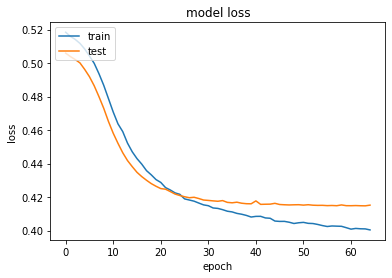

In [ ]:
plt.plot(history.history["loss"][5:])
plt.plot(history.history["val_loss"][5:])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

**Getting movies for given User**

In [ ]:
refined_dataset.head()

,user id,movie_title,rating,user,movie
0,1,101 Dalmatians (1996),2.0,0,2
1,1,12 Angry Men (1957),5.0,0,3
2,1,"20,000 Leagues Under the Sea (1954)",3.0,0,6
3,1,2001: A Space Odyssey (1968),4.0,0,7
4,1,"Abyss, The (1989)",3.0,0,16


How this DNN model works is, it takes two inputs, one of the input has user id's and the other has corresponding movie id's. Here DNN model tries to predict the ratings of the user - movie combination. So, we can input a specific user id (broadcasting it with the size of other input) and unseen movie id of the user and expect the model to give the ratings of the movies which would have been the ratings given by the user. Here, the ratings are already normalized and as we need the movies which interest the user more, ratings are not brought back to 0-5 scale.

In [ ]:
X_train_array

[array([180, 487, 177, ..., 431, 232, 138]),
 array([1152,  389,  302, ..., 1588,  399,  612])]

Above is the model input shape

In [ ]:
user_id = [100]
encoded_user_id = user_enc.transform(user_id)

seen_movies = list(refined_dataset[refined_dataset['user id'] == user_id[0]]['movie'])
print(seen_movies)

[32, 59, 80, 89, 92, 98, 166, 207, 264, 289, 293, 332, 333, 378, 379, 407, 460, 468, 476, 536, 572, 573, 577, 579, 585, 621, 636, 649, 655, 766, 767, 827, 828, 829, 860, 862, 928, 993, 1002, 1086, 1111, 1133, 1143, 1168, 1206, 1230, 1261, 1284, 1285, 1302, 1364, 1376, 1401, 1500, 1515, 1546, 1588, 1589, 1606]



Id's of movies which are already seen by the user are extracted.

In [ ]:
len(refined_dataset['movie'].unique()), min(refined_dataset['movie']), max(refined_dataset['movie'])

We can understand that the labels are from 0 to 1663. So the movie id's which are not seen by the user can be pciked just by excluding the 'seen_movies' list from the first 1663 natural numbers.





In [ ]:
#Movies which are not seen by the user.
unseen_movies = [i for i in range(min(refined_dataset['movie']), max(refined_dataset['movie'])+1) if i not in seen_movies]
print(unseen_movies)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 81, 82, 83, 84, 85, 86, 87, 88, 90, 91, 93, 94, 95, 96, 97, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228

In [ ]:
len(unseen_movies) + len(seen_movies)

1664

In [ ]:
model_input = [np.asarray(list(encoded_user_id)*len(unseen_movies)), np.asarray(unseen_movies)]
len(model_input), len(model_input[0])
     

(2, 1605)

**DNN model is used to predict the ratings of the unseen movies.**

In [ ]:
predicted_ratings = model.predict(model_input)

51/51 [==============================] - 0s 1ms/step


In [ ]:
print(predicted_ratings.shape)

(1605, 9)


In [ ]:
print(predicted_ratings)

[[9.8831302e-01 1.1682437e-02 2.6601322e-07 ... 6.3355310e-07
  1.2545992e-06 3.7838581e-07]
 [9.7010207e-01 2.9887602e-02 7.2180870e-07 ... 1.3508061e-06
  3.0295412e-06 8.8486274e-07]
 [9.9280959e-01 7.1879150e-03 1.4060326e-07 ... 3.7188585e-07
  7.2763686e-07 2.1759807e-07]
 ...
 [9.7941864e-01 2.0565659e-02 1.0691668e-06 ... 2.1487194e-06
  4.2201327e-06 1.3514738e-06]
 [9.7404581e-01 2.5939649e-02 9.8074474e-07 ... 1.9800559e-06
  3.8868825e-06 1.1869231e-06]
 [9.8071104e-01 1.9281009e-02 4.6980992e-07 ... 1.0857177e-06
  2.2393144e-06 6.4853117e-07]]


Output is of shape (1628, 9). We got probability of each possible rating from 1 to 5. We can extract specific rating which user would have given to a movie but it is not useful for these recommendations now.

In [ ]:
predicted_ratings = np.max(predicted_ratings, axis=1)
predicted_ratings

array([0.988313  , 0.9701021 , 0.9928096 , ..., 0.97941864, 0.9740458 ,
       0.98071104], dtype=float32)

In [ ]:
predicted_ratings.shape

(1605,)

Index of ratings sorted by descending order.

In [ ]:
sorted_index = np.argsort(predicted_ratings)[::-1]
print(sorted_index)

[1202 1425 1397 ... 1593 1234  307]


**Movie names have been extracted from the available indices we got.**

In [ ]:
recommended_movies = item_enc.inverse_transform(sorted_index)
recommended_movies

array(['Race the Sun (1996)', 'Sudden Death (1995)',
       'Star Trek: The Wrath of Khan (1982)', ...,
       'Walk in the Sun, A (1945)', 'Return of the Jedi (1983)',
       'City of Angels (1998)'], dtype=object)

**Movies recommended with the help of Softmax Deep Neural Networks**

In [ ]:
from pprint import pprint
pprint(list(recommended_movies[:20]))

['Race the Sun (1996)',
 'Sudden Death (1995)',
 'Star Trek: The Wrath of Khan (1982)',
 'Mars Attacks! (1996)',
 "Romy and Michele's High School Reunion (1997)",
 'Dream Man (1995)',
 'I.Q. (1994)',
 'JLG/JLG - autoportrait de décembre (1994)',
 'Cosi (1996)',
 'Mark of Zorro, The (1940)',
 'Batman Forever (1995)',
 'Paris, Texas (1984)',
 'To Die For (1995)',
 'Color of Night (1994)',
 'Children of the Corn: The Gathering (1996)',
 'Virtuosity (1995)',
 'Kicked in the Head (1997)',
 'Jack (1996)',
 'Terminator 2: Judgment Day (1991)',
 'Mighty, The (1998)']


**Summing up the entire code into a recommender system function:**

In [ ]:
def recommender_system(user_id, model, n_movies):

  print("")
  print("Movie seen by the User:")
  pprint(list(refined_dataset[refined_dataset['user id'] == user_id]['movie_title']))
  print("")

  encoded_user_id = user_enc.transform([user_id])

  seen_movies = list(refined_dataset[refined_dataset['user id'] == user_id]['movie'])
  unseen_movies = [i for i in range(min(refined_dataset['movie']), max(refined_dataset['movie'])+1) if i not in seen_movies]
  model_input = [np.asarray(list(encoded_user_id)*len(unseen_movies)), np.asarray(unseen_movies)]
  predicted_ratings = model.predict(model_input)
  predicted_ratings = np.max(predicted_ratings, axis=1)
  sorted_index = np.argsort(predicted_ratings)[::-1]
  recommended_movies = item_enc.inverse_transform(sorted_index)
  print("---------------------------------------------------------------------------------")
  print("Top "+str(n_movies)+" Movie recommendations for the User "+str(user_id)+ " are:")
  pprint(list(recommended_movies[:n_movies]))

In [ ]:
print("Enter user id")
user_id= int(input())

print("Enter number of movies to be recommended:")
n_movies = int(input())
recommender_system(user_id,model,n_movies)

Enter user id
50
Enter number of movies to be recommended:
5

Movie seen by the User:
['Anne Frank Remembered (1995)',
 'Basquiat (1996)',
 'Chasing Amy (1997)',
 'Cop Land (1997)',
 'Crash (1996)',
 'Dead Man Walking (1995)',
 'English Patient, The (1996)',
 'Everyone Says I Love You (1996)',
 'Fargo (1996)',
 'Frighteners, The (1996)',
 'I Shot Andy Warhol (1996)',
 'Leaving Las Vegas (1995)',
 'Lone Star (1996)',
 'Lost Highway (1997)',
 "Mr. Holland's Opus (1995)",
 'Mulholland Falls (1996)',
 'People vs. Larry Flynt, The (1996)',
 'Phenomenon (1996)',
 'Pillow Book, The (1995)',
 'Scream (1996)',
 "Things to Do in Denver when You're Dead (1995)",
 'Trainspotting (1996)',
 "Young Poisoner's Handbook, The (1995)"]

52/52 [==============================] - 0s 1ms/step
---------------------------------------------------------------------------------
Top 5 Movie recommendations for the User 50 are:
['Telling Lies in America (1997)',
 'Metisse (Café au Lait) (1993)',
 'Rent-a-Kid (1995)